In [10]:
import torch

In [11]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)
# y=(x+w)*(w+1)
a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)

# 第一次执行梯度求导
y.backward()
print(w.grad)
# 第二次执行梯度求导，出错
y.backward()

tensor([5.])


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [12]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)
# y=(x+w)*(w+1)
a = torch.add(w, x)
b = torch.add(w, 1)
y = torch.mul(a, b)
# 第一次求导，设置 retain_graph=True，保留计算图
y.backward(retain_graph=True)
print(w.grad)
# 第二次求导成功
y.backward()

tensor([5.])


In [13]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)

a = torch.add(w, x)
b = torch.add(w, 1)

y0 = torch.mul(a, b)    # y0 = (x+w) * (w+1)
y1 = torch.add(a, b)    # y1 = (x+w) + (w+1)    dy1/dw = 2

y0,y1

(tensor([6.], grad_fn=<MulBackward0>), tensor([5.], grad_fn=<AddBackward0>))

In [14]:
# 把两个 loss 拼接都到一起
loss = torch.cat([y0, y1], dim=0)       # [y0, y1]
loss

tensor([6., 5.], grad_fn=<CatBackward0>)

In [15]:
# 设置两个 loss 的权重: y0 的权重是 1，y1 的权重是 2
grad_tensors = torch.tensor([1., 2.])

loss.backward(gradient=grad_tensors)    # gradient 传入 torch.autograd.backward()中的grad_tensors
# 最终的 w 的导数由两部分组成。∂y0/∂w * 1 + ∂y1/∂w * 2
print(w.grad)

tensor([9.])


In [16]:
x = torch.tensor([3.], requires_grad=True)
y = torch.pow(x, 2)     # y = x**2
# 如果需要求 2 阶导，需要设置 create_graph=True，让一阶导数 grad_1 也拥有计算图
grad_1 = torch.autograd.grad(y, x, create_graph=True)   # grad_1 = dy/dx = 2x = 2 * 3 = 6
print(grad_1)
# 这里求 2 阶导
grad_2 = torch.autograd.grad(grad_1[0], x)              # grad_2 = d(dy/dx)/dx = d(2x)/dx = 2
print(grad_2)

(tensor([6.], grad_fn=<MulBackward0>),)
(tensor([2.]),)


In [19]:
w = torch.tensor([1.], requires_grad=True)
x = torch.tensor([2.], requires_grad=True)
# 进行 4 次反向传播求导，每次最后都没有清零
for i in range(4):
    # y = (w + x) / (w + 1)
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)
    y.backward()
    print(w.grad)

tensor([5.])
tensor([10.])
tensor([15.])
tensor([20.])


In [25]:
for i in range(4):
    # 每次都把梯度清零
    w.grad.zero_()
    a = torch.add(w, x)
    b = torch.add(w, 1)
    y = torch.mul(a, b)
    y.backward()
    print(w.grad)

tensor([5.])
tensor([5.])
tensor([5.])
tensor([5.])


## 逻辑回归

### Pytorch 实现逻辑回归
```
PyTorch 构建模型需要 5 大步骤：
数据：包括数据读取，数据清洗，进行数据划分和数据预处理，比如读取图片如何预处理及数据增强。
模型：包括构建模型模块，组织复杂网络，初始化网络参数，定义网络层。
损失函数：包括创建损失函数，设置损失函数超参数，根据不同任务选择合适的损失函数。
优化器：包括根据梯度使用某种优化器更新参数，管理模型参数，管理多个参数组实现不同学习率，调整学习率。
迭代训练：组织上面 4 个模块进行反复训练。包括观察训练效果，绘制 Loss/ Accuracy 曲线，用 TensorBoard 进行可视化分析。

In [23]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(10)

In [26]:
# ============================ step 1/5 生成数据 ============================
sample_nums = 100
mean_value = 1.7
bias = 1
n_data = torch.ones(sample_nums, 2)
# 使用正态分布随机生成样本，均值为张量，方差为标量
x0 = torch.normal(mean_value * n_data, 1) + bias      # 类别0 数据 shape=(100, 2)
# 生成对应标签
y0 = torch.zeros(sample_nums)                         # 类别0 标签 shape=(100, 1)
# 使用正态分布随机生成样本，均值为张量，方差为标量
x1 = torch.normal(-mean_value * n_data, 1) + bias     # 类别1 数据 shape=(100, 2)
# 生成对应标签
y1 = torch.ones(sample_nums)                          # 类别1 标签 shape=(100, 1)
train_x = torch.cat((x0, x1), 0)
train_y = torch.cat((y0, y1), 0)

In [27]:
# ============================ step 2/5 选择模型 ============================
class LR(nn.Module):
    def __init__(self):
        super(LR, self).__init__()
        self.features = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.features(x)
        x = self.sigmoid(x)
        return x

lr_net = LR()   # 实例化逻辑回归模型

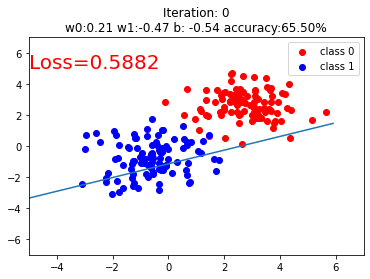

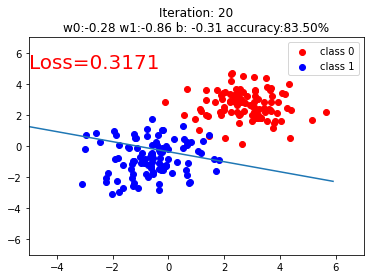

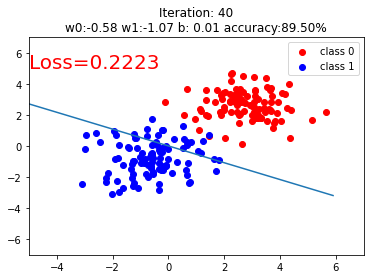

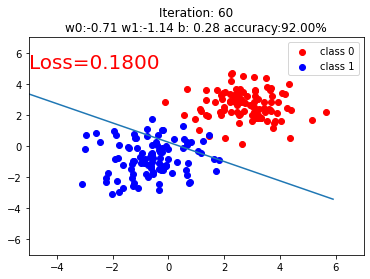

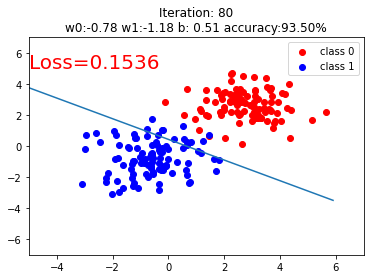

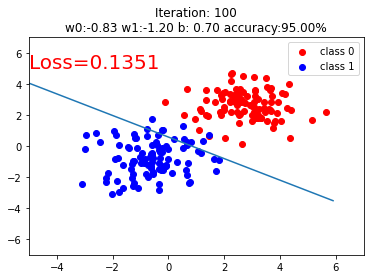

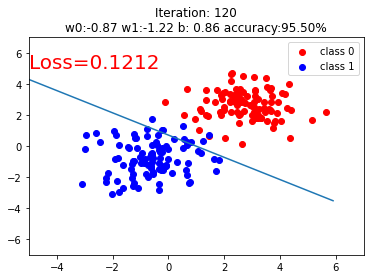

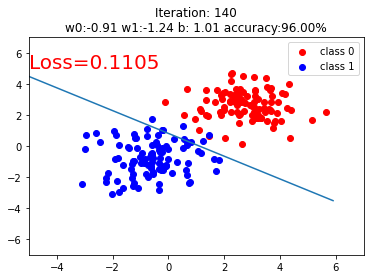

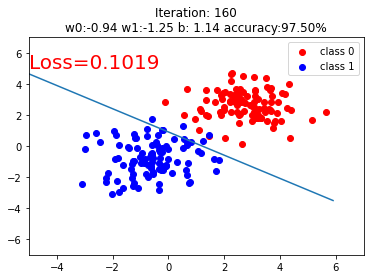

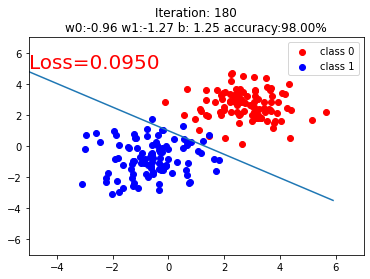

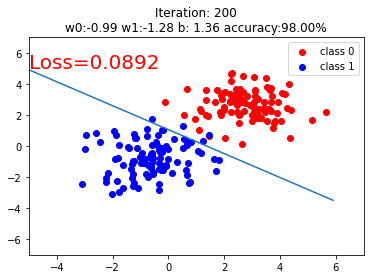

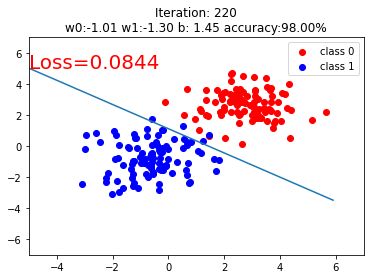

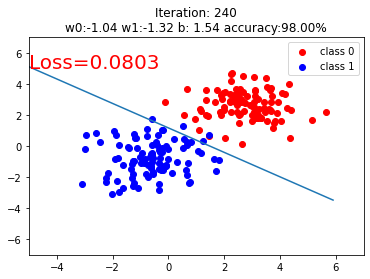

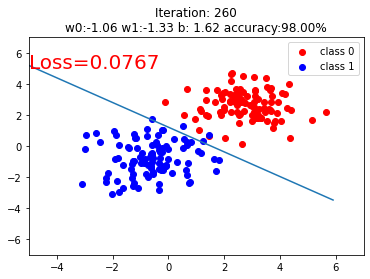

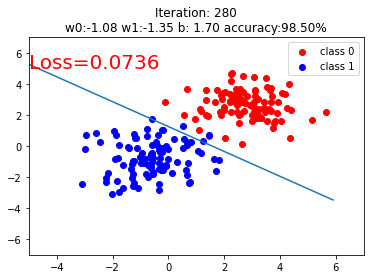

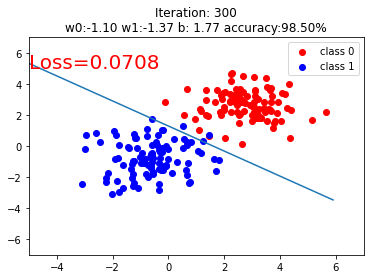

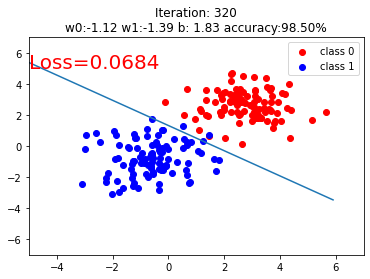

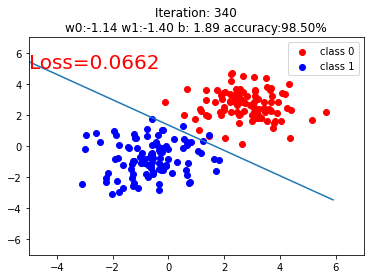

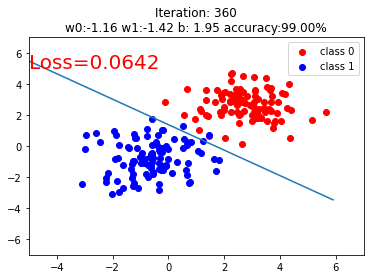

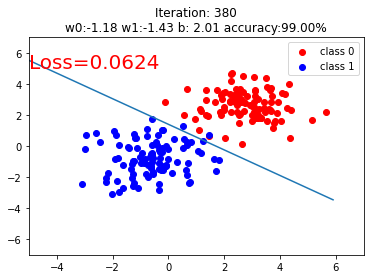

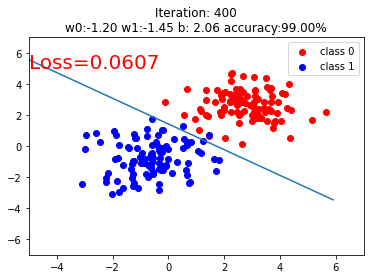

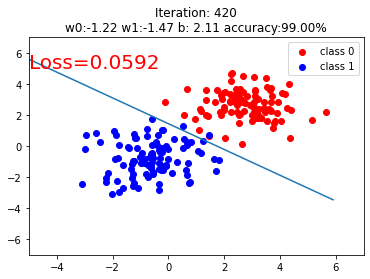

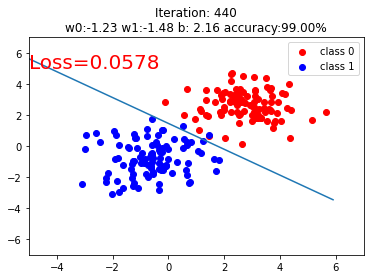

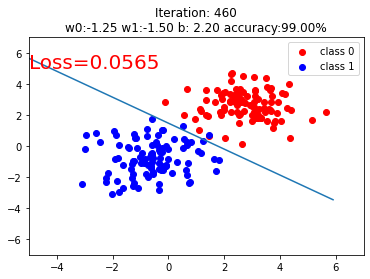

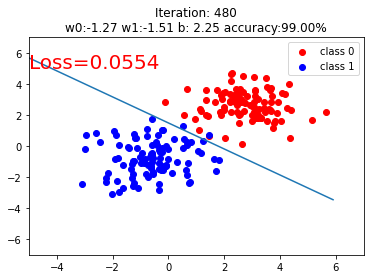

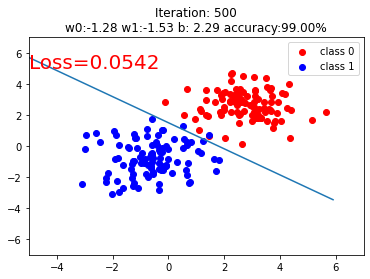

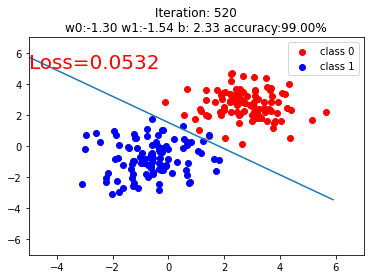

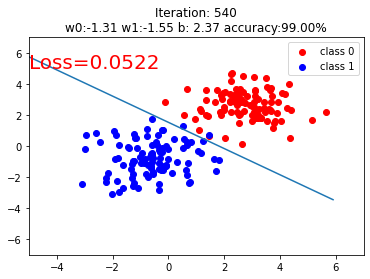

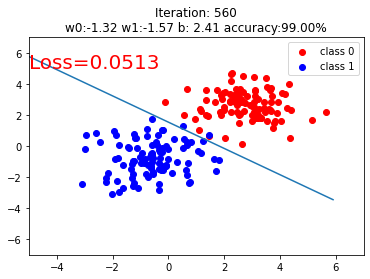

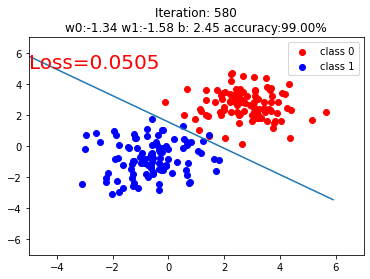

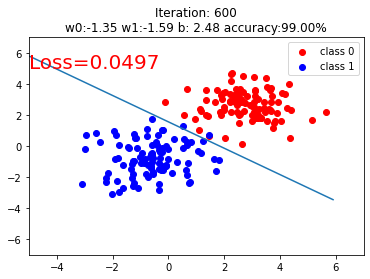

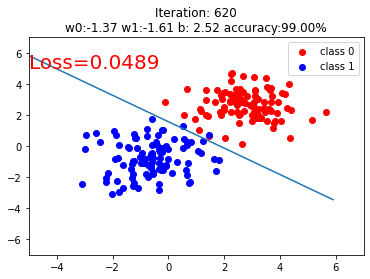

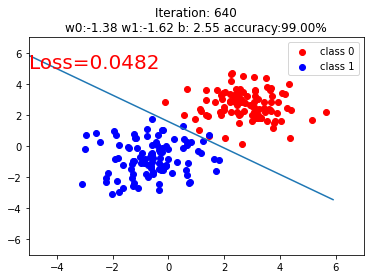

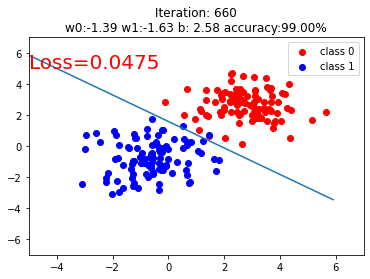

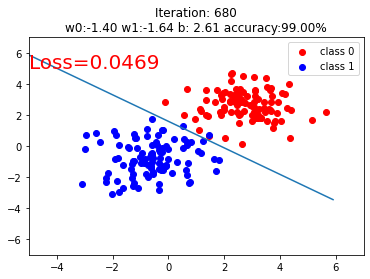

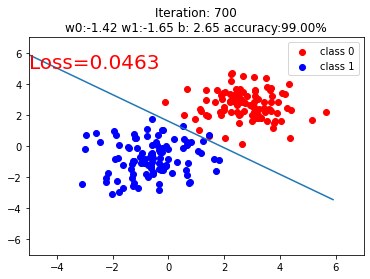

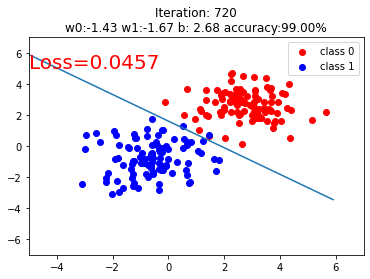

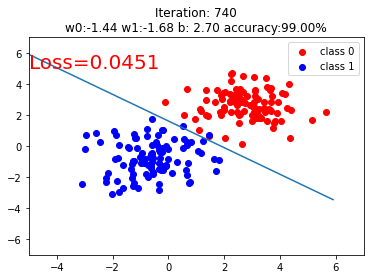

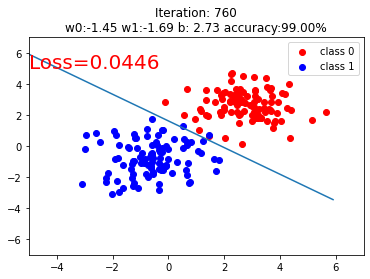

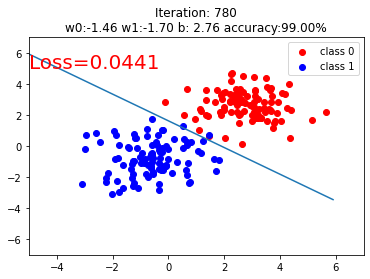

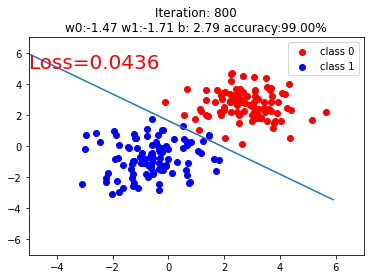

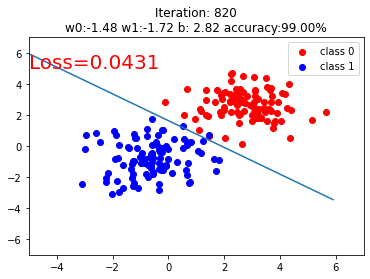

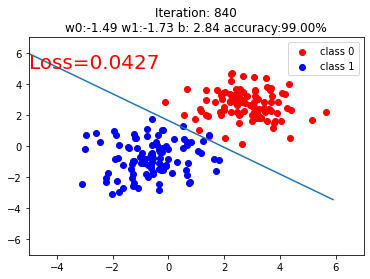

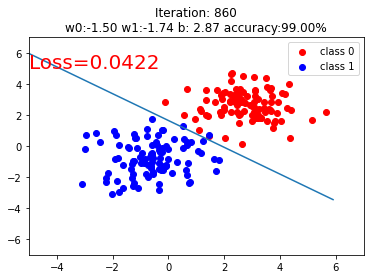

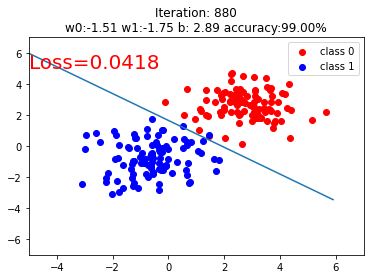

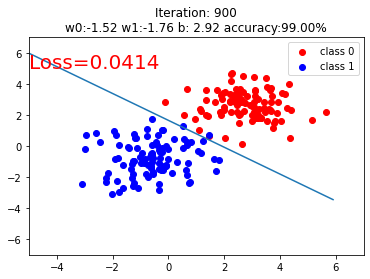

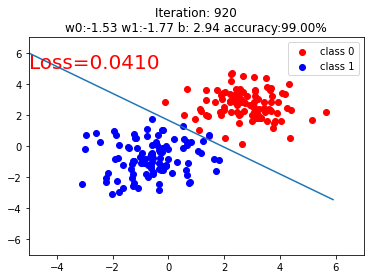

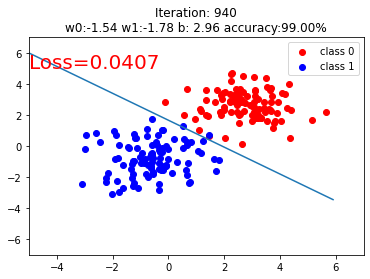

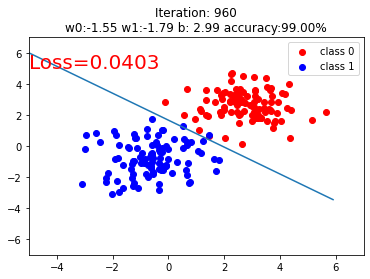

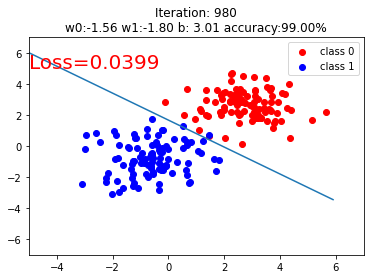

In [28]:
# ============================ step 3/5 选择损失函数 ============================
loss_fn = nn.BCELoss()

# ============================ step 4/5 选择优化器   ============================
lr = 0.01  # 学习率
optimizer = torch.optim.SGD(lr_net.parameters(), lr=lr, momentum=0.9)

# ============================ step 5/5 模型训练 ============================
for iteration in range(1000):

    # 前向传播
    y_pred = lr_net(train_x)
    # 计算 loss
    loss = loss_fn(y_pred.squeeze(), train_y)
    # 反向传播
    loss.backward()
    # 更新参数
    optimizer.step()
    # 清空梯度
    optimizer.zero_grad()
    # 绘图
    if iteration % 20 == 0:
        mask = y_pred.ge(0.5).float().squeeze()  # 以0.5为阈值进行分类
        correct = (mask == train_y).sum()  # 计算正确预测的样本个数
        acc = correct.item() / train_y.size(0)  # 计算分类准确率

        plt.scatter(x0.data.numpy()[:, 0], x0.data.numpy()[:, 1], c='r', label='class 0')
        plt.scatter(x1.data.numpy()[:, 0], x1.data.numpy()[:, 1], c='b', label='class 1')

        w0, w1 = lr_net.features.weight[0]
        w0, w1 = float(w0.item()), float(w1.item())
        plot_b = float(lr_net.features.bias[0].item())
        plot_x = np.arange(-6, 6, 0.1)
        plot_y = (-w0 * plot_x - plot_b) / w1

        plt.xlim(-5, 7)
        plt.ylim(-7, 7)
        plt.plot(plot_x, plot_y)

        plt.text(-5, 5, 'Loss=%.4f' % loss.data.numpy(), fontdict={'size': 20, 'color': 'red'})
        plt.title("Iteration: {}\nw0:{:.2f} w1:{:.2f} b: {:.2f} accuracy:{:.2%}".format(iteration, w0, w1, plot_b, acc))
        plt.legend()
        # plt.savefig(str(iteration / 20)+".png")
        plt.show()
        plt.pause(0.5)
        # 如果准确率大于 99%，则停止训练
        if acc > 0.99:
            break